In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#pip install -U ydata-profiling

In [3]:
import pandas as pd
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
#data = pd.read_csv("gdrive/My Drive/Colab Notebooks/SEC_Data/2022q4_secdata.csv")
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/SEC_Data/2022_secdata_WFL.csv")
data.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsGrantsInPeriodGross,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic
0,0,0000002178-22-000089,3.853470e+08,3.365790e+08,NaN,NaN,NaN,3.513100e+07,NaN,1353000.0,...,NaN,NaN,NaN,NaN,2787000.0,NaN,1.275652e+09,NaN,1.740300e+07,1.729200e+07
1,1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,NaN,6.865000e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.917500e+10,NaN,5.641000e+09,5.585000e+09
2,2,0000002969-22-000054,NaN,3.245700e+09,NaN,2.823380e+10,-4.302000e+09,NaN,2.257200e+09,133700000.0,...,NaN,1365000.0,205.93,237000.0,NaN,NaN,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08
3,3,0000003499-22-000027,NaN,NaN,NaN,NaN,3.503200e+07,6.728000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.354195e+09,NaN,2.050065e+07,2.050065e+07
4,4,0000003570-22-000106,5.600000e+08,NaN,5.407000e+09,NaN,NaN,8.686000e+09,NaN,198000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09


In [5]:
data.shape

(7429, 143)

In [6]:
df_fraud_labels = pd.read_csv("gdrive/My Drive/Colab Notebooks/SEC_Data/Fraud_Labels.csv")
df_fraud_labels.shape

(66, 1)

In [7]:
data["Fraud"] = data["adsh"].apply(lambda x: 1 if x in (df_fraud_labels.adsh.values) else 0)
data.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
0,0,0000002178-22-000089,3.853470e+08,3.365790e+08,NaN,NaN,NaN,3.513100e+07,NaN,1353000.0,...,NaN,NaN,NaN,2787000.0,NaN,1.275652e+09,NaN,1.740300e+07,1.729200e+07,0
1,1,0000002488-22-000170,3.658000e+09,7.042000e+09,6.022000e+09,2.530000e+09,-9.100000e+07,NaN,6.865000e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,6.917500e+10,NaN,5.641000e+09,5.585000e+09,0
2,2,0000002969-22-000054,NaN,3.245700e+09,NaN,2.823380e+10,-4.302000e+09,NaN,2.257200e+09,133700000.0,...,1365000.0,205.93,237000.0,NaN,NaN,2.668370e+10,5.162180e+10,6.673000e+08,6.648000e+08,0
3,3,0000003499-22-000027,NaN,NaN,NaN,NaN,3.503200e+07,6.728000e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.354195e+09,NaN,2.050065e+07,2.050065e+07,0
4,4,0000003570-22-000106,5.600000e+08,NaN,5.407000e+09,NaN,NaN,8.686000e+09,NaN,198000000.0,...,NaN,NaN,NaN,NaN,NaN,-8.750000e+09,1.591000e+09,1.009300e+09,1.009300e+09,0


In [8]:
data[data.Fraud == 1]

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
221,221,0000084839-22-000033,8.315400e+07,2.772000e+08,NaN,6.370130e+08,-3.028500e+07,210412000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.119872e+09,NaN,9.843280e+08,9.842160e+08,1
317,317,0000312069-22-000097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
318,318,0000312070-22-000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
450,450,0000773840-22-000071,1.260200e+10,1.419300e+10,1.492100e+10,NaN,-6.191000e+09,NaN,1.660100e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1
522,522,0000823277-22-000030,5.989390e+09,NaN,1.419061e+09,NaN,-4.564670e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.874376e+10,7.265288e+10,NaN,NaN,1
1060,1060,0000950170-22-022129,3.590000e+08,4.156000e+08,1.778000e+08,8.872000e+08,-1.567000e+08,NaN,5.100000e+08,NaN,...,2176302.0,53.94,NaN,3700000.0,NaN,7.755000e+08,2.325000e+09,8.632600e+07,8.449600e+07,1
1568,1568,0001008654-22-000045,2.205000e+08,1.675000e+08,5.493000e+08,NaN,-1.258100e+09,425600000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.103100e+09,NaN,2.042000e+08,1.916000e+08,1
1675,1675,0001050441-22-000074,NaN,NaN,NaN,NaN,-1.666110e+08,875058000.0,NaN,1.348400e+07,...,NaN,NaN,NaN,NaN,NaN,7.691110e+09,NaN,1.282680e+08,1.280170e+08,1
2098,2098,0001124610-22-000041,4.420000e+08,4.370000e+09,5.489000e+09,NaN,-1.800000e+07,NaN,4.350000e+08,1.787000e+09,...,NaN,NaN,NaN,276000000.0,NaN,2.697700e+10,NaN,1.692907e+09,1.681886e+09,1
2112,2112,0001131554-22-000027,2.319200e+07,9.575800e+07,1.219430e+08,NaN,-6.911100e+07,NaN,9.844780e+08,4.590000e+06,...,9198000.0,12.90,0.0,NaN,NaN,1.748070e+08,2.401520e+08,1.286030e+08,1.286030e+08,1


In [9]:
#profile = ProfileReport(data, minimal=True)

In [10]:
#profile.to_file("gdrive/My Drive/Colab Notebooks/SEC_Data/eda_report.html")

In [11]:
# For fraud label 0, taking random 150 rows
df_fraud = data[data.Fraud==1]

# For fraud label 1, taking random 150 rows
df_nonfraud = data[data.Fraud==0]
df_sampled = df_nonfraud.sample(n=150, random_state=42)

# Concatenate the two dataframes
data_sampled = pd.concat([df_fraud, df_sampled])
data_sampled.shape

(167, 144)

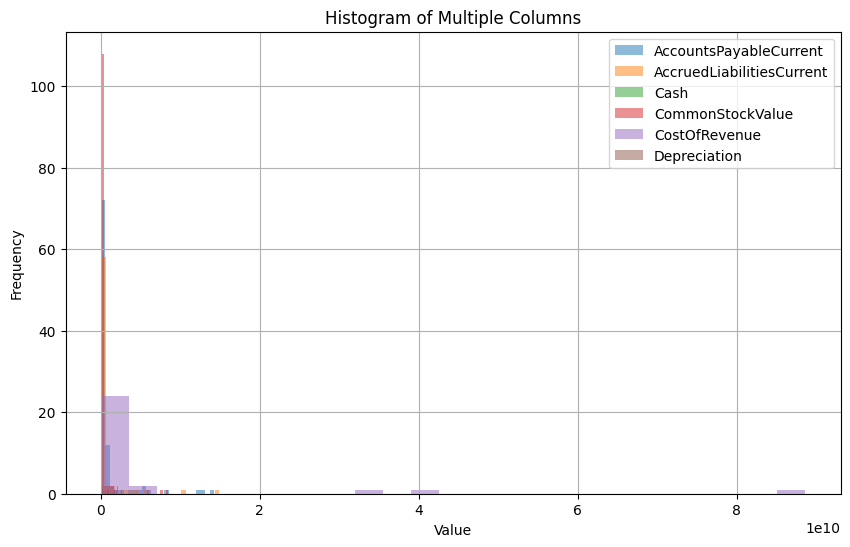

In [12]:
# Plot Histogram
colsforhist = ["AccountsPayableCurrent", "AccruedLiabilitiesCurrent", "Cash", "CommonStockValue", "CostOfRevenue", "Depreciation"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data_sampled[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

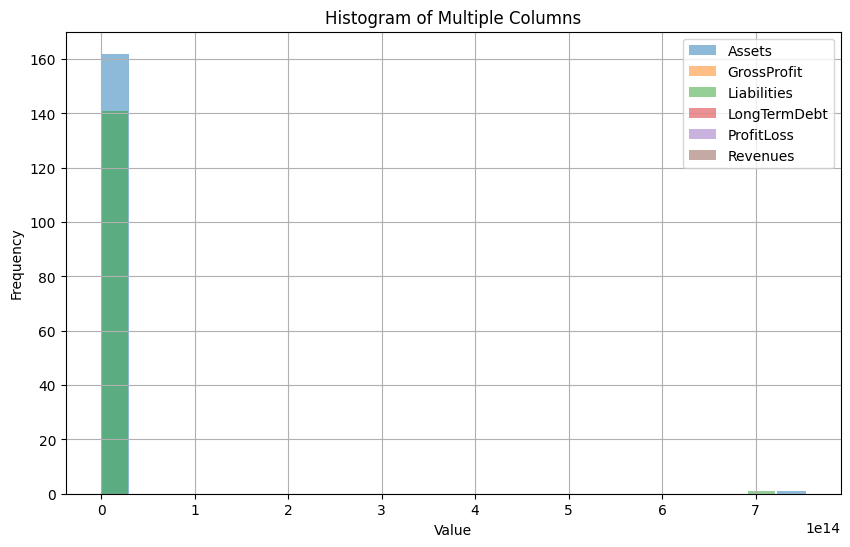

In [13]:
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data_sampled[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

In [14]:
# Missing value imputation
data_new = data_sampled.fillna(data_sampled.median())
data_new.head()

,Unnamed: 0,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
221,221,0000084839-22-000033,8.315400e+07,2.772000e+08,2.400600e+07,637013000.0,-3.028500e+07,210412000.0,7.541360e+08,13674000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.119872e+09,6.293413e+09,9.843280e+08,9.842160e+08,1
317,317,0000312069-22-000097,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1
318,318,0000312070-22-000018,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1
450,450,0000773840-22-000071,1.260200e+10,1.419300e+10,1.492100e+10,243830500.0,-6.191000e+09,235599275.5,1.660100e+10,13674000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1
522,522,0000823277-22-000030,5.989390e+09,7.338200e+07,1.419061e+09,243830500.0,-4.564670e+08,235599275.5,7.541360e+08,13674000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,1.874376e+10,7.265288e+10,2.426681e+08,2.282267e+08,1


In [15]:
data_new.drop(columns=["Unnamed: 0"], inplace=True)
data_new.head()

,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
221,0000084839-22-000033,8.315400e+07,2.772000e+08,2.400600e+07,637013000.0,-3.028500e+07,210412000.0,7.541360e+08,13674000.0,10059000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.119872e+09,6.293413e+09,9.843280e+08,9.842160e+08,1
317,0000312069-22-000097,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1
318,0000312070-22-000018,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1
450,0000773840-22-000071,1.260200e+10,1.419300e+10,1.492100e+10,243830500.0,-6.191000e+09,235599275.5,1.660100e+10,13674000.0,16473000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1
522,0000823277-22-000030,5.989390e+09,7.338200e+07,1.419061e+09,243830500.0,-4.564670e+08,235599275.5,7.541360e+08,13674000.0,16473000.0,...,5129500.0,18.725,282203.0,5740758.0,291000.0,1.874376e+10,7.265288e+10,2.426681e+08,2.282267e+08,1


In [16]:
data_new.loc[data_new.Liabilities==0]

,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud
1052,0000950170-22-022070,25821500.0,73382000.0,24006000.0,243830500.0,-18320000.0,-299692000.0,754135964.5,13674000.0,16473000.0,...,5129500.0,18.725,282203.0,4659000.0,291000.0,407958563.5,6.293413e+09,242668074.5,228226651.0,0


Feature Engineering

In [17]:
data_new["CurrentRatio"] = data_new.apply(lambda row: 0 if row["Liabilities"]==0 else row["AssetsCurrent"]/row["Liabilities"], axis=1 )
data_new["QuickRatio"] = data_new.apply(lambda row: 0 if row["Liabilities"]==0 else (row["AssetsCurrent"]-row["InventoryNet"])/row["Liabilities"], axis=1)
#data_new["DebttoEquityRatio"] = data_new.Liabilities/data_new.Equity
#data_new["ProfitMarginRatio"] = data_new.NetIncome2/data_new.NetSales
data_new = data_new.fillna(0)
data_new.head()

,adsh,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud,CurrentRatio,QuickRatio
221,0000084839-22-000033,8.315400e+07,2.772000e+08,2.400600e+07,637013000.0,-3.028500e+07,210412000.0,7.541360e+08,13674000.0,10059000.0,...,282203.0,5740758.0,291000.0,4.119872e+09,6.293413e+09,9.843280e+08,9.842160e+08,1,0.441571,0.411407
317,0000312069-22-000097,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,...,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1,0.000068,0.000008
318,0000312070-22-000018,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,...,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1,0.000087,0.000010
450,0000773840-22-000071,1.260200e+10,1.419300e+10,1.492100e+10,243830500.0,-6.191000e+09,235599275.5,1.660100e+10,13674000.0,16473000.0,...,282203.0,5740758.0,291000.0,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1,196.102621,152.543822
522,0000823277-22-000030,5.989390e+09,7.338200e+07,1.419061e+09,243830500.0,-4.564670e+08,235599275.5,7.541360e+08,13674000.0,16473000.0,...,282203.0,5740758.0,291000.0,1.874376e+10,7.265288e+10,2.426681e+08,2.282267e+08,1,77.686473,45.807074


In [18]:
# Plot skewness
skewness = data_new.drop(["adsh"], axis=1).apply(skew)

In [19]:
# Sort columns by skewness in descending order
sorted_skewness = skewness.sort_values(ascending=False)

# Get the top 10 columns with maximum skewness
top_20_skewness = sorted_skewness.head(20)

print(top_20_skewness)

CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents                             12.806481
LiabilitiesAndStockholdersEquity                                                          12.806475
OtherComprehensiveIncomeLossForeignCurrencyTransactionAndTranslationAdjustmentNetOfTax    12.806431
OtherComprehensiveIncomeLossNetOfTax                                                      12.806425
MinorityInterest                                                                          12.806422
InterestPaidNet                                                                           12.806412
FiniteLivedIntangibleAssetsNet                                                            12.806382
OperatingExpenses                                                                         12.806325
PreferredStockSharesIssued                                                                12.806226
PreferredStockSharesOutstanding                                                           12.806226


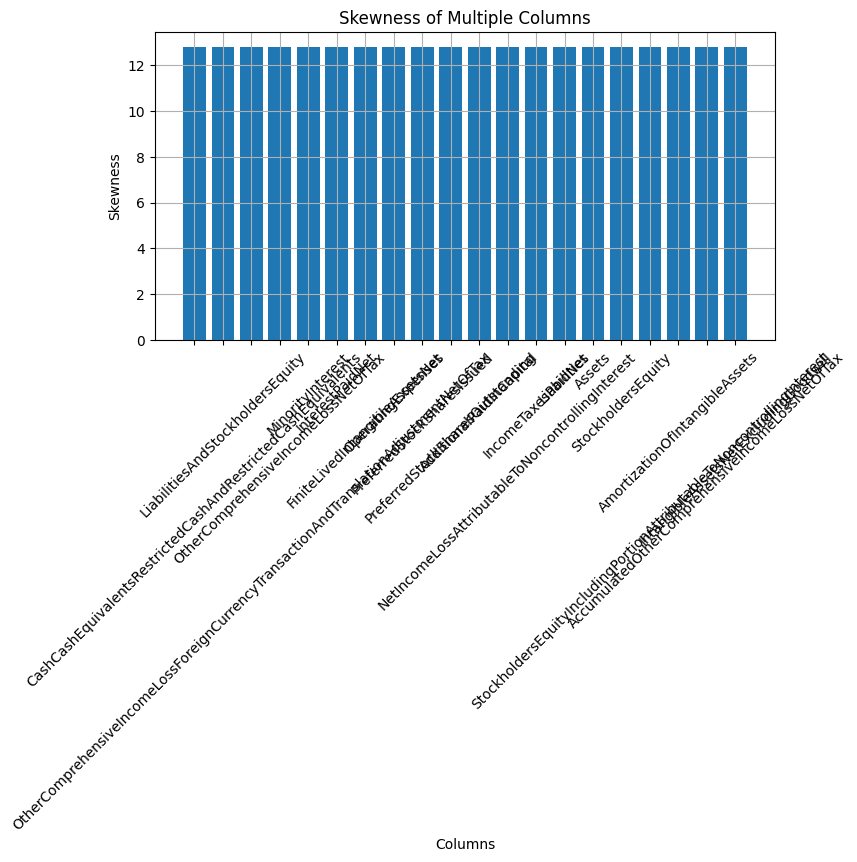

In [20]:
# Create a bar plot to visualize skewness
plt.figure(figsize=(8, 4))
plt.bar(top_20_skewness.index, top_20_skewness.values)
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of Multiple Columns')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)

plt.show()

In [21]:
# Generate summary statistics
summary_stats = data_new.describe()

# Display the summary statistics
summary_stats.to_csv('gdrive/My Drive/Colab Notebooks/SEC_Data/summary_stats.csv')


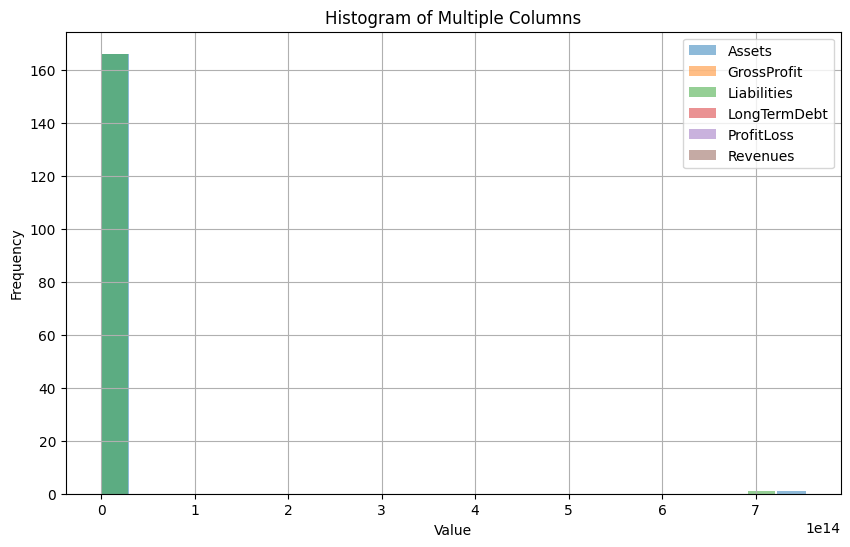

In [22]:
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues"]
plt.figure(figsize=(10, 6))  # Set the figure size
for column in colsforhist:
    plt.hist(data_new[column], bins=25, alpha=0.5, label=column)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Multiple Columns')
plt.legend()
plt.grid(True)

plt.show()

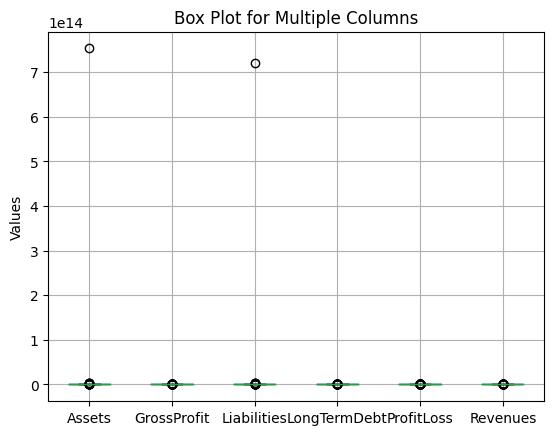

In [23]:
# Create a box plot for multiple columns
#plt.figure(figsize=(8, 6))
data_new.boxplot(column=colsforhist)
plt.title('Box Plot for Multiple Columns')
plt.ylabel('Values')
plt.show()

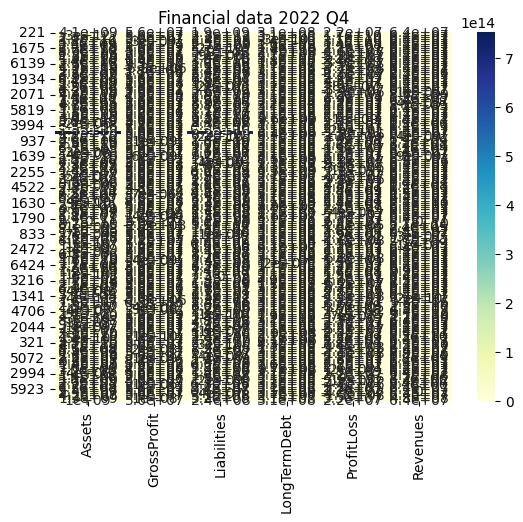

In [24]:
sns.heatmap(data_new[colsforhist], annot=True, cmap="YlGnBu")
plt.title("Financial data 2022 Q4")
plt.show()

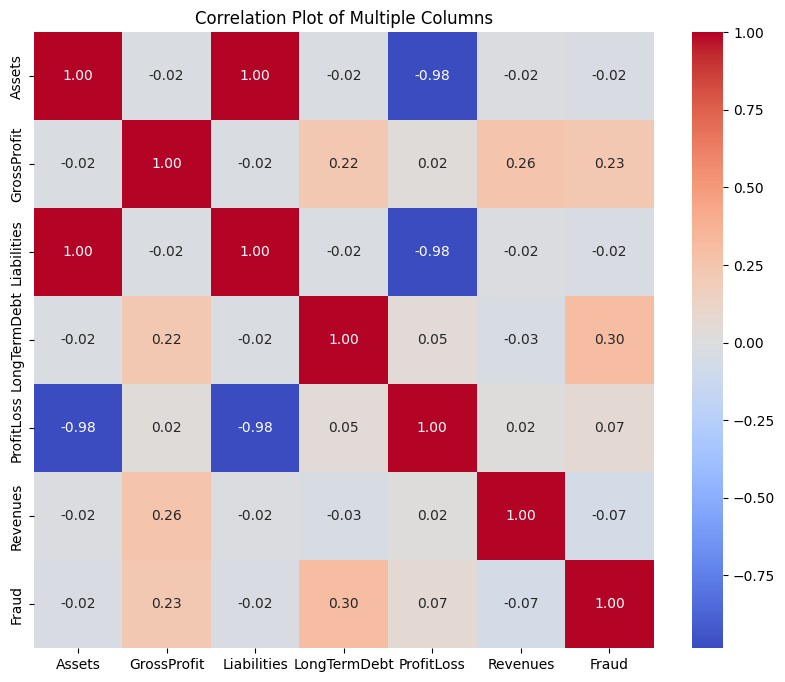

In [25]:
# Calculate the correlation matrix
colsforhist = ["Assets", "GrossProfit", "Liabilities", "LongTermDebt", "ProfitLoss", "Revenues", "Fraud"]
correlation_matrix = data_new[colsforhist].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Multiple Columns')
plt.show()

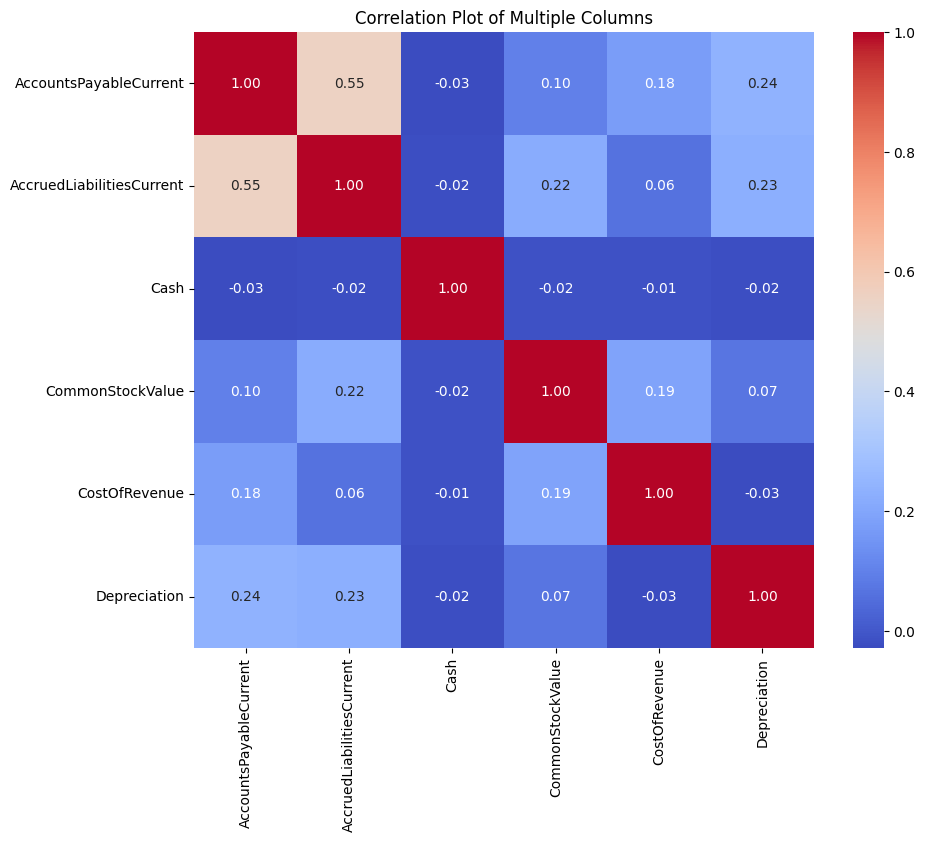

In [26]:
# Calculate the correlation matrix
colsforhist = ["AccountsPayableCurrent", "AccruedLiabilitiesCurrent", "Cash", "CommonStockValue", "CostOfRevenue", "Depreciation"]
correlation_matrix = data_new[colsforhist].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Multiple Columns')
plt.show()

In [27]:
data_final = data_new.drop(columns=["adsh"], axis=1)
data_final.head()


,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,Fraud,CurrentRatio,QuickRatio
221,8.315400e+07,2.772000e+08,2.400600e+07,637013000.0,-3.028500e+07,210412000.0,7.541360e+08,13674000.0,10059000.0,28055000.0,...,282203.0,5740758.0,291000.0,4.119872e+09,6.293413e+09,9.843280e+08,9.842160e+08,1,0.441571,0.411407
317,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,7404000.0,...,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1,0.000068,0.000008
318,2.582150e+07,7.338200e+07,2.400600e+07,243830500.0,-1.832000e+07,235599275.5,7.541360e+08,13674000.0,16473000.0,7404000.0,...,282203.0,5740758.0,291000.0,4.079586e+08,6.293413e+09,2.426681e+08,2.282267e+08,1,0.000087,0.000010
450,1.260200e+10,1.419300e+10,1.492100e+10,243830500.0,-6.191000e+09,235599275.5,1.660100e+10,13674000.0,16473000.0,526000000.0,...,282203.0,5740758.0,291000.0,3.627600e+10,5.568600e+10,2.765800e+09,2.737600e+09,1,196.102621,152.543822
522,5.989390e+09,7.338200e+07,1.419061e+09,243830500.0,-4.564670e+08,235599275.5,7.541360e+08,13674000.0,16473000.0,7404000.0,...,282203.0,5740758.0,291000.0,1.874376e+10,7.265288e+10,2.426681e+08,2.282267e+08,1,77.686473,45.807074


In [28]:
X = data_final.drop(columns=["Fraud"])
y = data_final["Fraud"]



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=100, stratify = y)
print("X_train shape : "+str(X_train.shape))
print("X_test shape : "+ str(X_test.shape))
print("y_train shape : "+ str(y_train.shape))
print("y_test shape : "+ str(y_test.shape))

X_train shape : (116, 143)
X_test shape : (51, 143)
y_train shape : (116,)
y_test shape : (51,)


In [30]:
X_train.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio
937,2.816900e+07,52737000.0,156240000.0,1.160760e+08,-18320000.0,2.355993e+08,7.541360e+08,13674000.0,46933000.0,7404000.0,...,26.560,311535.0,155498000.0,291000.0,3.327644e+09,8.602768e+09,931968604.0,921138492.0,0.450554,0.307102
6999,2.582150e+07,73382000.0,24006000.0,2.438305e+08,-12315000.0,1.685110e+08,7.541360e+08,13674000.0,16473000.0,7404000.0,...,18.725,282203.0,5740758.0,291000.0,3.165210e+08,9.255310e+08,24664000.0,23910000.0,0.058296,0.006812
6040,1.441800e+07,73382000.0,26456000.0,2.438305e+08,-519000.0,1.556852e+09,7.541360e+08,13674000.0,16473000.0,7404000.0,...,18.725,282203.0,5740758.0,291000.0,-1.301410e+08,6.293413e+09,216631898.0,216631898.0,0.572533,0.143510
5340,1.102160e+08,73382000.0,24006000.0,4.134240e+08,-18320000.0,2.355993e+08,3.972260e+08,6624000.0,7949000.0,7404000.0,...,18.725,282203.0,5740758.0,112000.0,1.657231e+09,6.293413e+09,82714221.0,81753939.0,0.691116,0.340127
3955,1.119750e+09,73382000.0,24006000.0,2.908222e+09,-6292000.0,2.355993e+08,1.586535e+09,13674000.0,16473000.0,4036000.0,...,18.725,282203.0,5740758.0,291000.0,2.903990e+09,5.901748e+09,199904000.0,180306000.0,20.768204,19.864712


In [31]:
#power = PowerTransformer(method='yeo-johnson', standardize=True)
#power = PowerTransformer(method='box-cox', standardize=True)
#X_train = power.fit_transform(X_train)
#X_test = power.transform(X_test)

In [32]:
# Save col names
saved_cols = X_train.columns

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Quantile Transformer
#qt = QuantileTransformer(
#    output_distribution="normal", random_state=304
#)
#X_train = qt.fit_transform(X_train)
#X_test = qt.transform(X_test)

In [34]:
X_train = pd.DataFrame(X_train, columns=saved_cols)
X_train.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio
0,-0.309218,-0.262190,-0.153517,-0.203310,-0.090543,-0.094186,-0.213765,-0.195659,0.132515,-0.175098,...,0.006801,-0.133772,0.996703,-0.158784,-0.093907,-0.093857,0.067088,0.091563,-0.121369,0.101322
1,-0.310567,-0.250897,-0.226120,-0.187199,-0.090504,-0.094254,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.155388,-0.167260,-0.207367,-0.158784,-0.094959,-0.095533,-0.285445,-0.277957,-0.123129,0.100829
2,-0.317120,-0.250897,-0.224775,-0.187199,-0.090427,-0.092843,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.155388,-0.167260,-0.207367,-0.158784,-0.095115,-0.094361,-0.210856,-0.198585,-0.120821,0.101054
3,-0.262068,-0.250897,-0.226120,-0.165811,-0.090543,-0.094186,-0.368505,-0.234522,-0.307632,-0.175098,...,-0.155388,-0.167260,-0.207367,-0.177878,-0.094491,-0.094361,-0.262890,-0.254134,-0.120289,0.101377
4,0.318084,-0.250897,-0.226120,0.148816,-0.090465,-0.094186,0.147126,-0.195659,-0.211393,-0.197651,...,-0.155388,-0.167260,-0.207367,-0.158784,-0.094055,-0.094447,-0.217355,-0.213546,-0.030168,0.133454


In [35]:
X_test = pd.DataFrame(X_test, columns=saved_cols)
X_test.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio
0,7.865982,12.571395,-0.226120,7.835244,-0.152764,-0.094186,0.041540,-0.195659,-0.211393,1.589953,...,-0.155388,-0.16726,-0.207367,-0.158784,-0.084161,-0.088910,1.066840,1.150364,0.786909,0.432851
1,-0.297433,-0.276461,-0.225267,-0.213851,-0.090543,-0.094008,-0.213765,-0.195659,-0.190765,-0.175098,...,-0.155388,-0.16726,-0.207367,-0.125610,-0.095073,-0.094361,-0.168780,-0.153986,-0.121838,0.101331
2,-0.310567,-0.250897,-0.226120,-0.187199,-0.091514,-0.093536,-0.213765,-0.196706,-0.211393,-0.175098,...,-0.155388,-0.16726,-0.207367,-0.158784,-0.092383,-0.094361,-0.245190,-0.235081,-0.123348,0.100820
3,-0.310567,-0.250897,-0.226120,-0.187199,-0.090402,-0.094186,0.161089,-0.195659,-0.211393,-0.175098,...,-0.155388,-0.16726,-0.207367,-0.158784,-0.094781,-0.094960,-0.159322,-0.144011,-0.122963,0.100836
4,-0.246696,-0.250897,-0.226120,-0.187199,-0.090543,-0.093044,-0.213765,-0.251230,-0.211393,-0.175098,...,-0.155388,-0.16726,-0.207367,-0.169664,-0.095152,-0.094361,0.256889,0.297204,-0.123020,0.099814


In [36]:
X_train.iloc[:5, :5]

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax
0,-0.309218,-0.262190,-0.153517,-0.203310,-0.090543
1,-0.310567,-0.250897,-0.226120,-0.187199,-0.090504
2,-0.317120,-0.250897,-0.224775,-0.187199,-0.090427
3,-0.262068,-0.250897,-0.226120,-0.165811,-0.090543
4,0.318084,-0.250897,-0.226120,0.148816,-0.090465


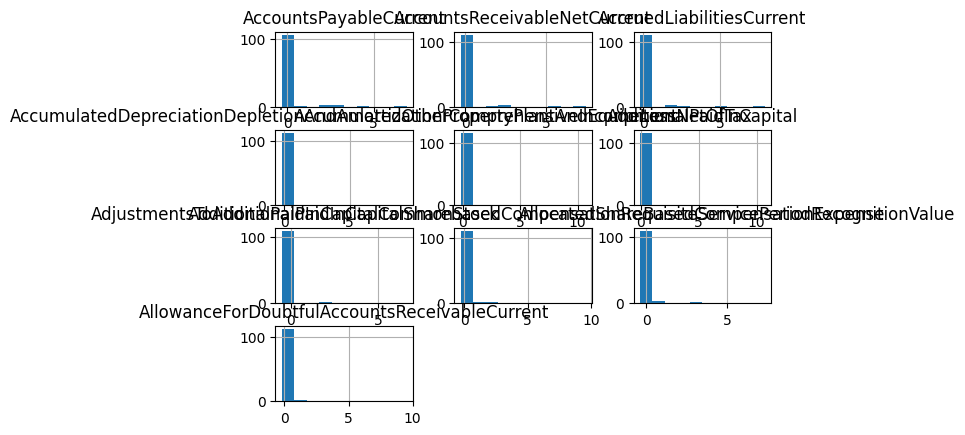

In [37]:
X_train.iloc[:, :10].hist()
plt.show()

In [38]:
y_train.value_counts()

0    104
1     12
Name: Fraud, dtype: int64

In [39]:
colsize = X_train.columns.size

class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=colsize, out_shape=colsize):

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train.iloc[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [40]:
# Training CGAN
cgan = cGAN()

In [41]:
y_train = y_train.values.reshape(-1,1)

In [42]:
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
pos_index

array([  8,  11,  31,  42,  45,  47,  51,  72,  78,  83,  91, 110])

1/1 [==============================] - 0s 25ms/step
[99/100]	Loss_D: 0.6750	Loss_G: 0.8213


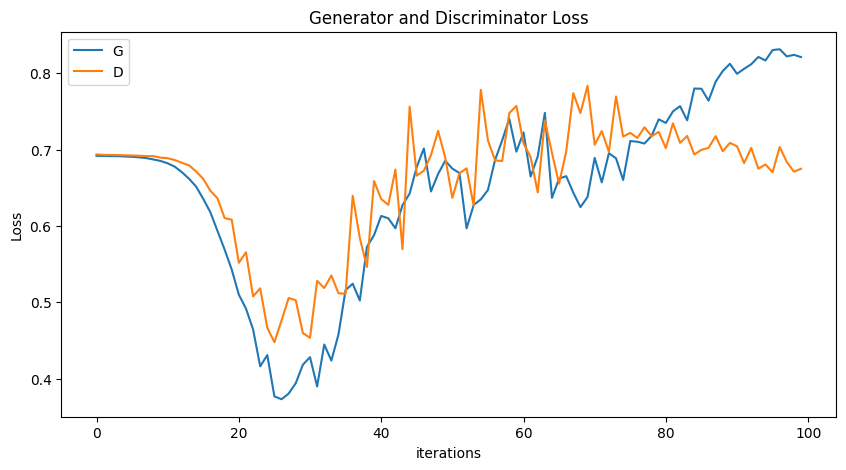

In [43]:
cgan.train(X_train, y_train, pos_index, neg_index, epochs=100, sampling=True)

In [44]:
# we want to generate 17 instances with class value 1 since that is the number of fraud data in original dataset
noise_2 = np.random.normal(0, 1, (17, colsize))
sampled_labels_2 = np.ones(17).reshape(-1, 1)
gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = X_train.columns)

1/1 [==============================] - 0s 131ms/step


In [45]:
# we want to generate 150 instances with class value 0 since that is the number of fraud data in original dataset
noise_3 = np.random.normal(0, 1, (150, colsize))
sampled_labels_3 = np.zeros(150).reshape(-1, 1)
gen_samples_3 = cgan.generator.predict([noise_3, sampled_labels_3])

gen_df_3 = pd.DataFrame(data = gen_samples_3,
                      columns = X_train.columns)

5/5 [==============================] - 0s 3ms/step


In [46]:
gen_df_2.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio
0,0.012812,0.262668,0.728713,0.553896,-0.348184,0.810383,-0.270248,0.253724,-0.498886,0.288644,...,-0.415419,-0.629546,0.793466,-0.188651,-0.833330,-0.800788,0.818989,0.586882,-0.735619,-0.381462
1,0.470967,0.967859,0.970547,0.942891,-0.329122,0.775726,0.889290,0.252400,-0.582732,0.866286,...,-0.538959,0.259837,0.629715,0.494858,-0.905395,-0.191825,0.858447,0.670539,-0.805122,0.784428
2,0.988904,0.986989,0.012507,-0.551120,0.892895,0.746693,0.966375,0.790163,0.488729,0.064869,...,0.249835,0.118330,-0.709398,0.164892,-0.515938,0.395361,0.607319,-0.455750,0.283071,0.277954
3,0.761691,0.765779,0.582339,0.927885,-0.543583,0.983229,0.937897,0.198313,-0.862590,0.959093,...,-0.360999,0.077494,0.953764,0.375609,-0.486728,-0.794487,0.938998,0.767618,-0.943895,0.419305
4,0.595603,0.802101,0.851891,0.761922,-0.848529,0.787919,0.455001,-0.047487,-0.332500,0.906611,...,-0.789006,0.228174,0.723911,-0.690479,-0.673819,-0.859669,0.845341,-0.614248,-0.715966,0.598722


In [47]:
gen_df_3.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingWeightedAverageExercisePrice,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio
0,-0.966627,-0.950574,-0.972324,0.448777,0.287140,0.668748,-0.932745,-0.298125,-0.766068,-0.984711,...,-0.802827,-0.677437,-0.078711,0.319073,0.943380,0.990468,0.472882,0.612575,0.832575,0.260590
1,0.912804,-0.566519,-0.708154,-0.920298,-0.410167,-0.828513,0.909649,0.982465,0.800871,0.648481,...,0.992377,-0.829715,-0.545261,0.847363,-0.228345,-0.936779,-0.937553,-0.924215,0.936089,-0.043154
2,-0.955121,-0.840116,-0.731019,-0.927219,0.764095,-0.815548,-0.995466,-0.067102,0.791035,0.619260,...,0.967354,-0.173434,-0.974488,-0.703717,0.864761,-0.492082,-0.840211,0.045828,-0.554985,-0.460845
3,-0.709167,-0.830623,-0.927090,-0.784904,-0.688116,-0.471961,-0.966466,-0.683962,0.739651,-0.860103,...,-0.608032,0.394193,-0.660264,-0.091049,0.860384,0.242261,-0.583629,-0.862713,0.935971,-0.795863
4,0.474692,0.391892,0.037148,-0.684599,0.714737,-0.971441,-0.298017,0.549189,0.955640,-0.151663,...,-0.727321,0.138793,0.070217,0.672849,0.523676,0.943606,-0.197962,-0.901556,0.984809,-0.733345


In [48]:
gen_df_2["Fraud"] = 1
gen_df_2.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio,Fraud
0,0.012812,0.262668,0.728713,0.553896,-0.348184,0.810383,-0.270248,0.253724,-0.498886,0.288644,...,-0.629546,0.793466,-0.188651,-0.833330,-0.800788,0.818989,0.586882,-0.735619,-0.381462,1
1,0.470967,0.967859,0.970547,0.942891,-0.329122,0.775726,0.889290,0.252400,-0.582732,0.866286,...,0.259837,0.629715,0.494858,-0.905395,-0.191825,0.858447,0.670539,-0.805122,0.784428,1
2,0.988904,0.986989,0.012507,-0.551120,0.892895,0.746693,0.966375,0.790163,0.488729,0.064869,...,0.118330,-0.709398,0.164892,-0.515938,0.395361,0.607319,-0.455750,0.283071,0.277954,1
3,0.761691,0.765779,0.582339,0.927885,-0.543583,0.983229,0.937897,0.198313,-0.862590,0.959093,...,0.077494,0.953764,0.375609,-0.486728,-0.794487,0.938998,0.767618,-0.943895,0.419305,1
4,0.595603,0.802101,0.851891,0.761922,-0.848529,0.787919,0.455001,-0.047487,-0.332500,0.906611,...,0.228174,0.723911,-0.690479,-0.673819,-0.859669,0.845341,-0.614248,-0.715966,0.598722,1


In [49]:
gen_df_3["Fraud"] = 0
gen_df_3.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio,Fraud
0,-0.966627,-0.950574,-0.972324,0.448777,0.287140,0.668748,-0.932745,-0.298125,-0.766068,-0.984711,...,-0.677437,-0.078711,0.319073,0.943380,0.990468,0.472882,0.612575,0.832575,0.260590,0
1,0.912804,-0.566519,-0.708154,-0.920298,-0.410167,-0.828513,0.909649,0.982465,0.800871,0.648481,...,-0.829715,-0.545261,0.847363,-0.228345,-0.936779,-0.937553,-0.924215,0.936089,-0.043154,0
2,-0.955121,-0.840116,-0.731019,-0.927219,0.764095,-0.815548,-0.995466,-0.067102,0.791035,0.619260,...,-0.173434,-0.974488,-0.703717,0.864761,-0.492082,-0.840211,0.045828,-0.554985,-0.460845,0
3,-0.709167,-0.830623,-0.927090,-0.784904,-0.688116,-0.471961,-0.966466,-0.683962,0.739651,-0.860103,...,0.394193,-0.660264,-0.091049,0.860384,0.242261,-0.583629,-0.862713,0.935971,-0.795863,0
4,0.474692,0.391892,0.037148,-0.684599,0.714737,-0.971441,-0.298017,0.549189,0.955640,-0.151663,...,0.138793,0.070217,0.672849,0.523676,0.943606,-0.197962,-0.901556,0.984809,-0.733345,0


In [50]:
real_data = pd.concat([X_train, pd.DataFrame(y_train, columns=["Fraud"])], axis=1)
real_data.head()


,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio,Fraud
0,-0.309218,-0.262190,-0.153517,-0.203310,-0.090543,-0.094186,-0.213765,-0.195659,0.132515,-0.175098,...,-0.133772,0.996703,-0.158784,-0.093907,-0.093857,0.067088,0.091563,-0.121369,0.101322,0
1,-0.310567,-0.250897,-0.226120,-0.187199,-0.090504,-0.094254,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.167260,-0.207367,-0.158784,-0.094959,-0.095533,-0.285445,-0.277957,-0.123129,0.100829,0
2,-0.317120,-0.250897,-0.224775,-0.187199,-0.090427,-0.092843,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.167260,-0.207367,-0.158784,-0.095115,-0.094361,-0.210856,-0.198585,-0.120821,0.101054,0
3,-0.262068,-0.250897,-0.226120,-0.165811,-0.090543,-0.094186,-0.368505,-0.234522,-0.307632,-0.175098,...,-0.167260,-0.207367,-0.177878,-0.094491,-0.094361,-0.262890,-0.254134,-0.120289,0.101377,0
4,0.318084,-0.250897,-0.226120,0.148816,-0.090465,-0.094186,0.147126,-0.195659,-0.211393,-0.197651,...,-0.167260,-0.207367,-0.158784,-0.094055,-0.094447,-0.217355,-0.213546,-0.030168,0.133454,0


In [51]:
df_gan = pd.concat([real_data, gen_df_2, gen_df_3], axis=0, ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)
df_gan.head()


,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllocatedShareBasedCompensationExpense,AllowanceForDoubtfulAccountsReceivableCurrent,...,StockIssuedDuringPeriodSharesStockOptionsExercised,StockIssuedDuringPeriodValueNewIssues,StockIssuedDuringPeriodValueStockOptionsExercised,StockholdersEquity,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CurrentRatio,QuickRatio,Fraud
0,-0.325290,-0.250897,-0.238007,-0.187199,-0.090543,-0.094425,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.167260,-0.253323,-0.158784,-0.095113,-0.094361,-0.200739,-0.193810,-0.123284,0.090662,0
1,-0.966627,-0.950574,-0.972324,0.448777,0.287140,0.668748,-0.932745,-0.298125,-0.766068,-0.984711,...,-0.677437,-0.078711,0.319073,0.943380,0.990468,0.472882,0.612575,0.832575,0.260590,0
2,-0.850073,-0.959100,-0.178597,-0.888677,-0.972036,-0.876881,-0.682765,-0.325485,-0.913792,0.653451,...,-0.824895,0.954713,0.933433,0.182881,0.608241,0.222109,0.866935,-0.934318,-0.490343,0
3,-0.310567,-0.256274,-0.226120,-0.187199,-0.090402,-0.094186,-0.290157,-0.201182,-0.211393,-0.065725,...,-0.167260,0.439577,-0.158784,-0.094566,-0.094361,-0.265989,-0.257199,-0.120437,0.101471,0
4,-0.325391,-0.250897,-0.239078,-0.187199,-0.090543,-0.094425,-0.213765,-0.195659,-0.211393,-0.175098,...,-0.167260,-0.174727,-0.158784,-0.095114,-0.095742,-0.200739,-0.193810,-0.122889,0.092524,0


In [52]:
X_train_2 = df_gan.drop('Fraud', axis=1)
y_train_2 = df_gan['Fraud'].values
#X_train_2.fillna(X_train_2.median())

In [53]:
# Experiment 1 - LGBM
# Classify using generated train set
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred_gan_lgbm_test = lgb_1.predict(X_test)
y_pred_gan_lgbm_train = lgb_1.predict(X_train)

#print(classification_report(y_test, y_pred_gan_lgbm))
#ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
#plt.show()

[LightGBM] [Info] Number of positive: 29, number of negative: 254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10502
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102473 -> initscore=-2.170038
[LightGBM] [Info] Start training from score -2.170038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [54]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_gan_lgbm_test)
recall_test = recall_score(y_test, y_pred_gan_lgbm_test)
f1_test = f1_score(y_test, y_pred_gan_lgbm_test)
accuracy_test = accuracy_score(y_test, y_pred_gan_lgbm_test)

precision_train = precision_score(y_train, y_pred_gan_lgbm_train)
recall_train = recall_score(y_train, y_pred_gan_lgbm_train)
f1_train = f1_score(y_train, y_pred_gan_lgbm_train)
accuracy_train = accuracy_score(y_train, y_pred_gan_lgbm_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000          1.0
1     Recall    0.000000          1.0
2   F1 Score    0.000000          1.0
3   Accuracy    0.862745          1.0


In [55]:
# lgb_1 feature importance
df_feature_importance1 = (
    pd.DataFrame({
        'feature': lgb_1.feature_name_,
        'importance': lgb_1.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance1.head(20)

,feature,importance
41,EntityCommonStockSharesOutstanding,111
24,CommonStockSharesOutstanding,80
77,LiabilitiesCurrent,65
2,AccruedLiabilitiesCurrent,64
142,QuickRatio,47
88,NonoperatingIncomeExpense,35
125,RetainedEarningsAccumulatedDeficit,30
47,FiniteLivedIntangibleAssetsNet,30
94,OperatingLeaseLiabilityCurrent,28
141,CurrentRatio,27


In [56]:
# Classify using original train set
lgb_2 = lgb.LGBMClassifier()
lgb_2.fit(X_train, y_train)


y_pred_lgbm_test = lgb_2.predict(X_test)
y_pred_lgbm_train = lgb_2.predict(X_train)

#print(classification_report(y_test, y_pred_lgbm))
#ConfusionMatrixDisplay.from_estimator(lgb_2, X_test, y_test)
#plt.show()

[LightGBM] [Info] Number of positive: 12, number of negative: 104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103448 -> initscore=-2.159484
[LightGBM] [Info] Start training from score -2.159484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [57]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_lgbm_test)
recall_test = recall_score(y_test, y_pred_lgbm_test)
f1_test = f1_score(y_test, y_pred_lgbm_test)
accuracy_test = accuracy_score(y_test, y_pred_lgbm_test)

precision_train = precision_score(y_train, y_pred_lgbm_train)
recall_train = recall_score(y_train, y_pred_lgbm_train)
f1_train = f1_score(y_train, y_pred_lgbm_train)
accuracy_train = accuracy_score(y_train, y_pred_lgbm_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.500000          1.0
1     Recall    0.200000          1.0
2   F1 Score    0.285714          1.0
3   Accuracy    0.901961          1.0


In [59]:
# lgb_2 feature importance
df_feature_importance2 = (
    pd.DataFrame({
        'feature': lgb_2.feature_name_,
        'importance': lgb_2.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance2.head(20)

,feature,importance
120,ProfitLoss,32
23,CommonStockSharesIssued,28
141,CurrentRatio,28
12,Assets,24
85,NetIncomeLoss,24
2,AccruedLiabilitiesCurrent,23
140,WeightedAverageNumberOfSharesOutstandingBasic,22
125,RetainedEarningsAccumulatedDeficit,20
142,QuickRatio,18
84,NetCashProvidedByUsedInOperatingActivities,17


Experiment 2 - XGBOD

In [60]:
pip install -U pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.1-py3-none-any.whl size=190074 sha256=9febbceccd40a2d01aa1d98732eedbff420f6ee846777379a1de4e31a7887b30
  Stored in directory: /root/.cache/pip/wheels/a3/42/d7/48a53ffc1466bd63932f28583c64ebf442114db14a0bfa8c95
Successfully built pyod


In [61]:
from pyod.models.xgbod import XGBOD

In [62]:
#Original data
# Initialize the XGBOD model
model = XGBOD()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict outliers on the test data
y_test_pred_xgbod_test = model.predict(X_test)
y_test_pred_xgbod_train = model.predict(X_train)

In [63]:
# Calculate metrics
precision_test = precision_score(y_test, y_test_pred_xgbod_test)
recall_test = recall_score(y_test, y_test_pred_xgbod_test)
f1_test = f1_score(y_test, y_test_pred_xgbod_test)
accuracy_test = accuracy_score(y_test, y_test_pred_xgbod_test)

precision_train = precision_score(y_train, y_test_pred_xgbod_train)
recall_train = recall_score(y_train, y_test_pred_xgbod_train)
f1_train = f1_score(y_train, y_test_pred_xgbod_train)
accuracy_train = accuracy_score(y_train, y_test_pred_xgbod_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    1.000000     1.000000
1     Recall    0.200000     0.833333
2   F1 Score    0.333333     0.909091
3   Accuracy    0.921569     0.982759


In [64]:
# Augmented data
# Initialize the XGBOD model
model2 = XGBOD()

# Fit the model to the training data
model2.fit(X_train_2, y_train_2)

# Predict outliers on the test data
y_test_pred_gan_xgbod_test = model2.predict(X_test)
y_test_pred_gan_xgbod_train = model2.predict(X_train)

In [65]:
# Calculate metrics
precision_test = precision_score(y_test, y_test_pred_gan_xgbod_test)
recall_test = recall_score(y_test, y_test_pred_gan_xgbod_test)
f1_test = f1_score(y_test, y_test_pred_gan_xgbod_test)
accuracy_test = accuracy_score(y_test, y_test_pred_gan_xgbod_test)

precision_train = precision_score(y_train, y_test_pred_gan_xgbod_train)
recall_train = recall_score(y_train, y_test_pred_gan_xgbod_train)
f1_train = f1_score(y_train, y_test_pred_gan_xgbod_train)
accuracy_train = accuracy_score(y_train, y_test_pred_gan_xgbod_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000     0.916667
1     Recall    0.000000     0.916667
2   F1 Score    0.000000     0.916667
3   Accuracy    0.901961     0.982759


Experiment 3 - SVM

In [66]:
from sklearn.svm import SVC

In [67]:
#Original data
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svm_test = svm_classifier.predict(X_test)
y_pred_svm_train = svm_classifier.predict(X_train)

In [68]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_svm_test)
recall_test = recall_score(y_test, y_pred_svm_test)
f1_test = f1_score(y_test, y_pred_svm_test)
accuracy_test = accuracy_score(y_test, y_pred_svm_test)

precision_train = precision_score(y_train, y_pred_svm_train)
recall_train = recall_score(y_train, y_pred_svm_train)
f1_train = f1_score(y_train, y_pred_svm_train)
accuracy_train = accuracy_score(y_train, y_pred_svm_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000     1.000000
1     Recall    0.000000     0.750000
2   F1 Score    0.000000     0.857143
3   Accuracy    0.823529     0.974138


In [69]:
# Augmented data
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train_2, y_train_2)

# Make predictions on the test data
y_pred_gan_svm_test = svm_classifier.predict(X_test)
y_pred_gan_svm_train = svm_classifier.predict(X_train)

In [70]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_gan_svm_test)
recall_test = recall_score(y_test, y_pred_gan_svm_test)
f1_test = f1_score(y_test, y_pred_gan_svm_test)
accuracy_test = accuracy_score(y_test, y_pred_gan_svm_test)

precision_train = precision_score(y_train, y_pred_gan_svm_train)
recall_train = recall_score(y_train, y_pred_gan_svm_train)
f1_train = f1_score(y_train, y_pred_gan_svm_train)
accuracy_train = accuracy_score(y_train, y_pred_gan_svm_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000     1.000000
1     Recall    0.000000     0.666667
2   F1 Score    0.000000     0.800000
3   Accuracy    0.882353     0.965517


Experiment 4 - Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
# Original data
# Create a logistic regression classifier
logistic_classifier = LogisticRegression()

# Train the logistic regression classifier on the training data
logistic_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgreg_test = logistic_classifier.predict(X_test)
y_pred_lgreg_train= logistic_classifier.predict(X_train)

In [73]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_lgreg_test)
recall_test = recall_score(y_test, y_pred_lgreg_test)
f1_test = f1_score(y_test, y_pred_lgreg_test)
accuracy_test = accuracy_score(y_test, y_pred_lgreg_test)

precision_train = precision_score(y_train, y_pred_lgreg_train)
recall_train = recall_score(y_train, y_pred_lgreg_train)
f1_train = f1_score(y_train, y_pred_lgreg_train)
accuracy_train = accuracy_score(y_train, y_pred_lgreg_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000     1.000000
1     Recall    0.000000     0.583333
2   F1 Score    0.000000     0.736842
3   Accuracy    0.843137     0.956897


In [74]:
# Augmented data
# Create a logistic regression classifier
logistic_classifier2 = LogisticRegression()

# Train the logistic regression classifier on the training data
logistic_classifier2.fit(X_train_2, y_train_2)

# Make predictions on the test data
y_pred_gan_lgreg_test = logistic_classifier2.predict(X_test)
y_pred_gan_lgreg_train = logistic_classifier2.predict(X_train)

In [75]:
# Calculate metrics
precision_test = precision_score(y_test, y_pred_gan_lgreg_test)
recall_test = recall_score(y_test, y_pred_gan_lgreg_test)
f1_test = f1_score(y_test, y_pred_gan_lgreg_test)
accuracy_test = accuracy_score(y_test, y_pred_gan_lgreg_test)

precision_train = precision_score(y_train, y_pred_gan_lgreg_train)
recall_train = recall_score(y_train, y_pred_gan_lgreg_train)
f1_train = f1_score(y_train, y_pred_gan_lgreg_train)
accuracy_train = accuracy_score(y_train, y_pred_gan_lgreg_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

      Metric  Score Test  Score Train
0  Precision    0.000000     1.000000
1     Recall    0.000000     0.583333
2   F1 Score    0.000000     0.736842
3   Accuracy    0.862745     0.956897


Build LGBM models with top 20 features

In [91]:
df_feature_importance2.feature.values[0:19]

array(['ProfitLoss', 'CommonStockSharesIssued', 'CurrentRatio', 'Assets',
       'NetIncomeLoss', 'AccruedLiabilitiesCurrent',
       'WeightedAverageNumberOfSharesOutstandingBasic',
       'RetainedEarningsAccumulatedDeficit', 'QuickRatio',
       'NetCashProvidedByUsedInOperatingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInFinancingActivities',
       'EntityCommonStockSharesOutstanding',
       'PaymentsToAcquirePropertyPlantAndEquipment',
       'EffectiveIncomeTaxRateContinuingOperations',
       'CommonStockSharesOutstanding',
       'CashAndCashEquivalentsAtCarryingValue',
       'LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths',
       'LiabilitiesAndStockholdersEquity'], dtype=object)

In [92]:
# Original Data
X_train_Top20 = X_train[df_feature_importance2.feature.values[0:19]]
X_test_Top20 = X_test[df_feature_importance2.feature.values[0:19]]

In [93]:
# Augmented Data
X_train_2_Top20 = X_train_2[df_feature_importance2.feature.values[0:19]]

In [94]:
X_train_Top20.head()

,ProfitLoss,CommonStockSharesIssued,CurrentRatio,Assets,NetIncomeLoss,AccruedLiabilitiesCurrent,WeightedAverageNumberOfSharesOutstandingBasic,RetainedEarningsAccumulatedDeficit,QuickRatio,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,EntityCommonStockSharesOutstanding,PaymentsToAcquirePropertyPlantAndEquipment,EffectiveIncomeTaxRateContinuingOperations,CommonStockSharesOutstanding,CashAndCashEquivalentsAtCarryingValue,LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths,LiabilitiesAndStockholdersEquity
0,0.066330,-0.150808,-0.121369,-0.093363,0.077869,-0.153517,0.091563,-0.259517,0.101322,-0.099579,0.093718,0.093950,-0.294581,-0.075764,2.564542,-0.303628,-0.326344,-0.091827,-0.093358
1,0.067603,-0.191722,-0.123129,-0.093355,0.074539,-0.226120,-0.277957,-0.243461,0.100829,-0.099190,0.093512,0.093861,-0.508066,-0.100656,0.058885,-0.544627,-0.326344,-0.123880,-0.093375
2,0.066330,-0.152094,-0.120821,-0.093429,0.055791,-0.224775,-0.198585,-0.391339,0.101054,-0.106595,0.095430,0.093352,-0.287140,-0.101022,0.058885,-0.310432,-0.351264,-0.119668,-0.093423
3,0.066351,-0.179614,-0.120289,-0.093421,0.073937,-0.226120,-0.254134,-0.254999,0.101377,-0.102128,0.094718,0.093508,-0.447271,-0.094060,0.495104,-0.303628,-0.365571,-0.109668,-0.093415
4,0.076187,-0.142250,-0.030168,-0.093325,0.080340,-0.226120,-0.213546,-0.152892,0.133454,-0.102145,0.094907,0.093193,-0.347622,-0.082833,-0.250250,-0.252259,0.047252,-0.119668,-0.093320


In [95]:
lgb_3 = lgb.LGBMClassifier()
lgb_3.fit(X_train_Top20, y_train)


new_y_pred_lgbm_test = lgb_3.predict(X_test_Top20)
new_y_pred_lgbm_train = lgb_3.predict(X_train_Top20)

# Calculate metrics
precision_test = precision_score(y_test, new_y_pred_lgbm_test)
recall_test = recall_score(y_test, new_y_pred_lgbm_test)
f1_test = f1_score(y_test, new_y_pred_lgbm_test)
accuracy_test = accuracy_score(y_test, new_y_pred_lgbm_test)

precision_train = precision_score(y_train, new_y_pred_lgbm_train)
recall_train = recall_score(y_train, new_y_pred_lgbm_train)
f1_train = f1_score(y_train, new_y_pred_lgbm_train)
accuracy_train = accuracy_score(y_train, new_y_pred_lgbm_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

[LightGBM] [Info] Number of positive: 12, number of negative: 104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103448 -> initscore=-2.159484
[LightGBM] [Info] Start training from score -2.159484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [98]:
lgb_4 = lgb.LGBMClassifier()
lgb_4.fit(X_train_2_Top20, y_train_2)


new_y_pred_lgbm_GAN_test = lgb_4.predict(X_test_Top20)
new_y_pred_lgbm_GAN_train = lgb_4.predict(X_train_2_Top20)

# Calculate metrics
precision_test = precision_score(y_test, new_y_pred_lgbm_GAN_test)
recall_test = recall_score(y_test, new_y_pred_lgbm_GAN_test)
f1_test = f1_score(y_test, new_y_pred_lgbm_GAN_test)
accuracy_test = accuracy_score(y_test, new_y_pred_lgbm_GAN_test)

precision_train = precision_score(y_train_2, new_y_pred_lgbm_GAN_train)
recall_train = recall_score(y_train_2, new_y_pred_lgbm_GAN_train)
f1_train = f1_score(y_train_2, new_y_pred_lgbm_GAN_train)
accuracy_train = accuracy_score(y_train_2, new_y_pred_lgbm_GAN_train)

# Create a results DataFrame
results = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
                        'Score Test': [precision_test, recall_test, f1_test, accuracy_test],
                        'Score Train': [precision_train, recall_train, f1_train, accuracy_train]})

# Print the results in a tabular format
print(results)

[LightGBM] [Info] Number of positive: 29, number of negative: 254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102473 -> initscore=-2.170038
[LightGBM] [Info] Start training from score -2.170038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best